# A Monte Carlo simulation technique to determine the optimal portfolio - <br> Hassan Ghodrati and Zahra Zahiri

Objective : Determine asset allocation using Monte Carlo simulation and the weight of optimal investment is determined using a hybrid model called Markowitz and Winker model. 

### Calculating VaR using Monte Carlo Simulations

#### Steps to Calculate VaR using Monte Carlo
1. Collect Historical data
2. Calculate daily log returns
3. Compute mean and standard deviation of the log returns of each company
4. Use Monte Carlo method to simulate future returns based on the mean and std_dev from step 3
5. Compute value of the portfolio for each simulation
6. Determine VaR at the specified confidence level from the simulated portfolio values

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf 
from datetime import datetime, timedelta
import statsmodels.api as sm 
from scipy.stats import skew, kurtosis 
from scipy.optimize import minimize  
plt.style.use('seaborn-v0_8-dark-palette') 
import warnings
warnings.filterwarnings('ignore') 

#### 1. Fetch Data

In [2]:
start_date = '2011-01-01' 
end_date = '2019-12-30' 

tickers = ['AAPL','AMD','NVDA','MSFT','TSLA','AMZN']  

In [3]:
data = pd.DataFrame() 
for tick in tickers:
    data[f'{tick}'] = yf.download(tick,start=start_date,end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2011-01-03,9.951282,8.47,0.362763,21.585310,1.774667,9.2110
2011-01-04,10.003218,8.77,0.361617,21.670177,1.778000,9.2505
2011-01-05,10.085045,8.91,0.389363,21.600742,1.788667,9.3710
2011-01-06,10.076890,8.69,0.443250,22.233334,1.858667,9.2930
2011-01-07,10.149056,8.83,0.455632,22.063622,1.882667,9.2745


#### 2. Calculate Daily Log Returns

In [5]:
log_returns = np.log(data/data.shift(1)).dropna() 
log_returns.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2011-01-04,0.005205,0.034806,-0.003166,0.003924,0.001876,0.004279
2011-01-05,0.008147,0.015837,0.073927,-0.003209,0.005981,0.012942
2011-01-06,-0.000809,-0.025001,0.129622,0.028865,0.038389,-0.008358
2011-01-07,0.007136,0.015982,0.027553,-0.007663,0.012830,-0.001993
2011-01-10,0.018657,0.039961,0.037535,-0.013376,0.007409,-0.004376


#### 3. Defining number of simulations and Time Horizon

In [6]:
num_sims = 1000
time_horizon = 1    # One day

confidence_level = 0.95 

#### 4. Plotting the Distribution of each stocks

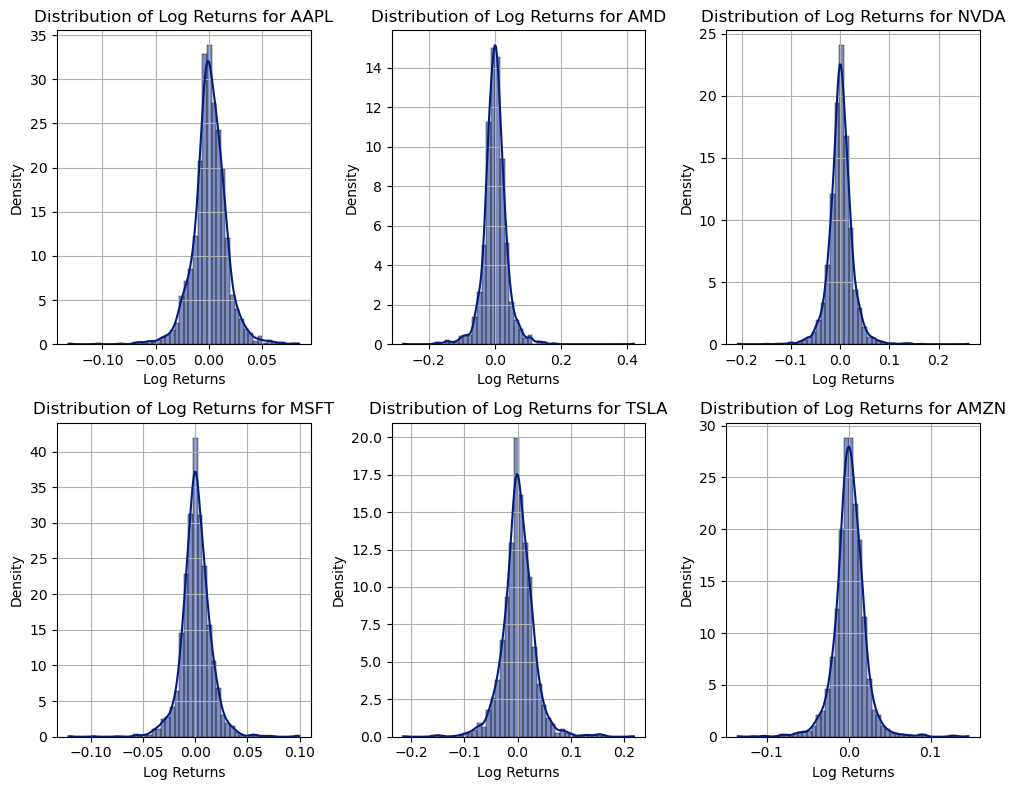

In [7]:
# Number of subplots
num_plots = len(log_returns.columns)
rows = (num_plots // 3) + int(num_plots % 3 != 0)

# Create subplots
fig, axes = plt.subplots(rows, 3, figsize=(10, 4 * rows))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each histogram
for i, tick in enumerate(log_returns.columns):
    sns.histplot(log_returns[tick], bins=50, kde=True, stat='density', ax=axes[i])
    axes[i].set_title(f'Distribution of Log Returns for {tick}')
    axes[i].set_xlabel('Log Returns')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show() 

We can see that the log returns of these stocks follow normal distribution

#### 5. QQ Plot to check Normality 

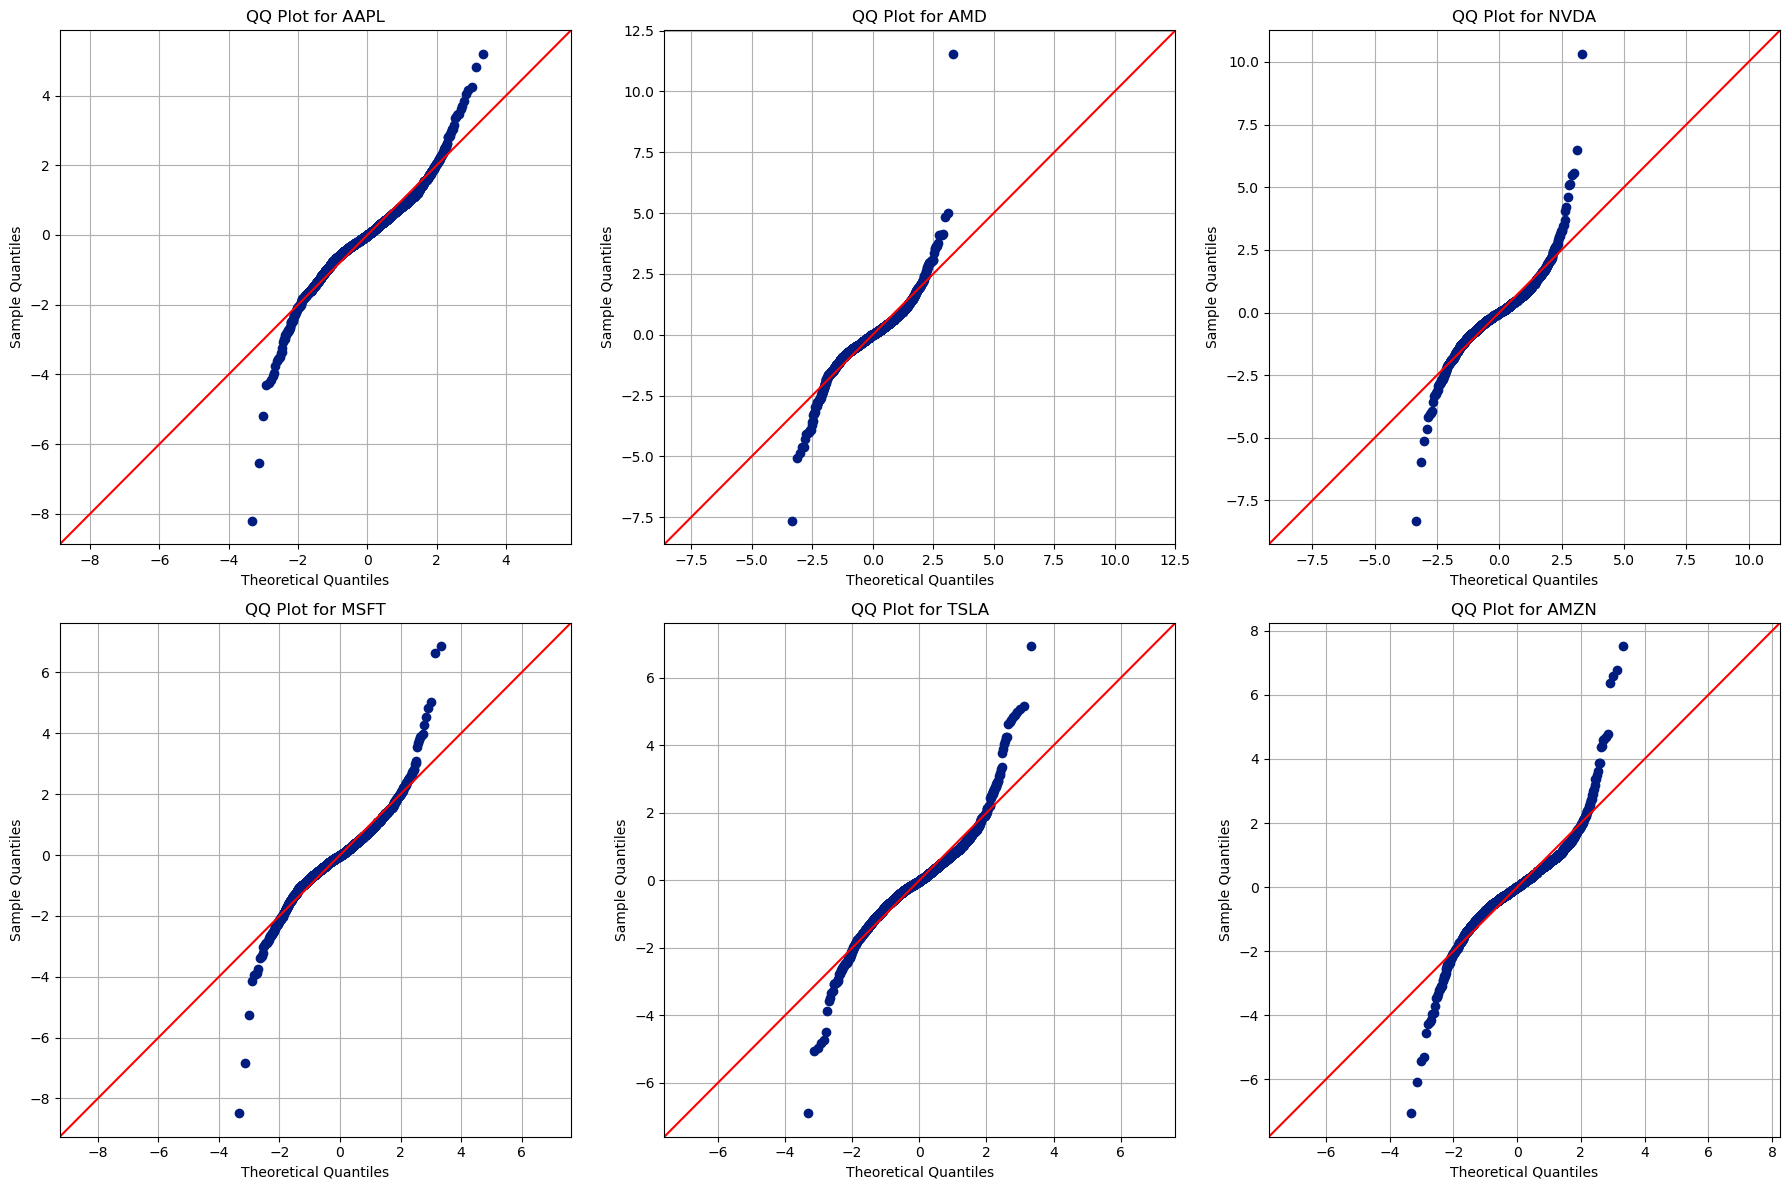

In [8]:
# Number of subplots
num_plots = len(log_returns.columns)
rows = (num_plots // 3) + int(num_plots % 3 != 0)

# Create subplots
fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each histogram
for i, tick in enumerate(log_returns.columns):
    ax = axes[i]
    sm.qqplot(log_returns[tick], line='45', fit=True, ax=ax) 
    axes[i].set_title(f'QQ Plot for {tick}')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show() 

#### 6. Calculating VaR for each stock using Monte Carlo Simulation

In [9]:
VaRs={} 

for tick in tickers:
    mean_return = log_returns[tick].mean() 
    std_return = log_returns[tick].std() 

    # Simulate Future Returns using Monte Carlo
    simulated_returns = np.random.normal(mean_return,std_return,num_sims) 

    # Calculate VaR
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    VaRs[tick] = -VaR 

# Output VaRs for each stock
for tick in tickers:
    print(f'Value at Risk for {tick} at {confidence_level*100}% confidence level : ${VaRs[tick]:.2f}') 

Value at Risk for AAPL at 95.0% confidence level : $0.03
Value at Risk for AMD at 95.0% confidence level : $0.06
Value at Risk for NVDA at 95.0% confidence level : $0.04
Value at Risk for MSFT at 95.0% confidence level : $0.02
Value at Risk for TSLA at 95.0% confidence level : $0.05
Value at Risk for AMZN at 95.0% confidence level : $0.03


Interpretation : Value at Risk for AAPL at 95.0% confidence level : $0.03 

There is a 95% probability that the loss will be less than or equal to $0.03.
Conversely, there is a 5% chance that the loss will exceed $0.03.

In [10]:
VaR_df= pd.DataFrame()
VaR_df = pd.DataFrame(list(VaRs.items()), columns=['Ticker', 'VaR (per $)']) 
VaR_df  

,Ticker,VaR (per $)
0,AAPL,0.025116
1,AMD,0.061540
2,NVDA,0.040251
3,MSFT,0.021829
4,TSLA,0.050341
5,AMZN,0.029760


Total amount to be invested in the portfolio is 60000\$ and should be equally divided among the assets

In [11]:
capital = 60000
amnt_asset = capital/len(tickers) 

VaR_df['Amount at risk (in $)'] = (VaR_df['VaR (per $)']*amnt_asset).round(4)

print(f'Total amount at Risk in the portfolio : {VaR_df['Amount at risk (in $)'].sum():.4f}$') 

VaR_df.head()  

Total amount at Risk in the portfolio : 2288.3721$


,Ticker,VaR (per $),Amount at risk (in $)
0,AAPL,0.025116,251.1618
1,AMD,0.061540,615.4000
2,NVDA,0.040251,402.5099
3,MSFT,0.021829,218.2905
4,TSLA,0.050341,503.4059


#### 7. Predicting Value for next day

Expected log returns of historical data is considered as the prediction varible for next day

Here, we are finding out the **num_sims** possibilities for next day using monte carlo and using its expectation values for calculating next day price

In [12]:
predictions = {} 

for tick in tickers:
    mean_return = log_returns[tick].mean() 
    std_return = log_returns[tick].std() 

    # Simulate future returns using Monte Carlo
    simulated_returns = np.random.normal(mean_return,std_return,num_sims) 

    # predict Next Day Price
    current_price = data[tick].iloc[-1]  # Get last available price
    predicted_prices = current_price*np.exp(simulated_returns)

    predictions[tick] = predicted_prices    

#### 8. Analyzing Predictions

In [13]:
mean_prices = []
median_prices = []
lower_percentiles = []
upper_percentiles = [] 

for tick in tickers:
    predicted_prices = predictions[tick] 
    mean_price = np.mean(predicted_prices)
    median_price = np.median(predicted_prices) 
    lower_percentile = np.percentile(predicted_prices,2.5) 
    upper_percentile = np.percentile(predicted_prices,97.5)

    mean_prices.append((mean_price).round(4))
    median_prices.append((median_price).round(4))
    lower_percentiles.append((lower_percentile.round(4)))
    upper_percentiles.append((upper_percentile.round(4))) 

data_preds = pd.DataFrame({'Mean predctd price($)':mean_prices,'Median predctd price($)':median_prices,
                           '2.5th percentile($)':lower_percentiles,'97.5th percentile($)':upper_percentiles}
                           ,index=tickers) 
data_preds['95% Confidence interval($)'] = list(zip(data_preds['2.5th percentile($)'],
                                                 data_preds['97.5th percentile($)']))
data_preds.head() 

,Mean predctd price($),Median predctd price($),2.5th percentile($),97.5th percentile($),95% Confidence interval($)
AAPL,70.5525,70.5445,68.1938,72.8003,"(68.1938, 72.8003)"
AMD,46.1965,46.1771,42.8708,49.4679,"(42.8708, 49.4679)"
NVDA,5.9004,5.8993,5.6168,6.1901,"(5.6168, 6.1901)"
MSFT,152.6258,152.6078,148.4038,156.8388,"(148.4038, 156.8388)"
TSLA,28.7921,28.7356,27.1581,30.6797,"(27.1581, 30.6797)"


# Optimization using Hybrid Model

#### Steps for Optimization
1. From simulated future prices, calculate simulated prices for each stock
2. Calculate Covariance matrix of these predicted returns
3. Setup objective function to maximize expected return or minimize variance
4. Define constraints
5. Use optimization techniques such as quadratic programming for Markowitz and non-lonear programming for hybrid model

In [14]:
predicted_returns = pd.DataFrame(predictions).pct_change().dropna() 
predicted_returns.head() 

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
1,0.020624,0.009449,0.014671,0.002426,-0.005476,0.028909
2,0.000855,-0.041774,-0.009575,0.029878,0.007602,0.000057
3,-0.026419,0.023900,0.014325,-0.033328,0.014417,0.003920
4,0.011104,0.001471,-0.004714,0.024467,-0.007004,-0.030305
5,0.020546,-0.079080,0.023143,-0.003407,0.034017,0.031565


In [15]:
predicted_returns.shape 

(999, 6)

#### 9. Computing Expected Returns and Statistics for each stock

In [16]:
def rets_stats(predicted_returns):
    expected_returns = predicted_returns.mean() 
    cov_matrix = predicted_returns.cov() 
    skewness = predicted_returns.apply(lambda x:skew(x)) 
    kurtoses = predicted_returns.apply(lambda x:kurtosis(x))
    return expected_returns, cov_matrix, skewness, kurtoses 

In [17]:
expected_returns, cov_matrix, skewness, kurtoses = rets_stats(predicted_returns) 

df_stats = pd.DataFrame(index=tickers) 
df_stats['Expected Returns'] = expected_returns
df_stats['Skewness'] = skewness
df_stats['Kurtosis'] = kurtoses

print() 
print('==========Covariance Matrix==========')
print(cov_matrix) 
print() 
df_stats 


==========Covariance Matrix==========
          AAPL       AMD      NVDA      MSFT      TSLA      AMZN
AAPL  0.000517 -0.000076 -0.000036  0.000002 -0.000003 -0.000015
AMD  -0.000076  0.002697  0.000152  0.000028  0.000052 -0.000026
NVDA -0.000036  0.000152  0.001230 -0.000029  0.000008 -0.000011
MSFT  0.000002  0.000028 -0.000029  0.000367 -0.000011  0.000034
TSLA -0.000003  0.000052  0.000008 -0.000011  0.001876  0.000012
AMZN -0.000015 -0.000026 -0.000011  0.000034  0.000012  0.000755



,Expected Returns,Skewness,Kurtosis
AAPL,0.000287,0.003051,-0.192468
AMD,0.001372,0.029884,0.140857
NVDA,0.000607,0.076567,-0.002656
MSFT,0.000183,0.137042,0.125156
TSLA,0.001005,0.203384,0.327612
AMZN,0.000355,0.004893,-0.244482


#### 10. Optimization Functions for hybrid Model

In [18]:
def portfolio_variance(weights,cov_matrix):
    return np.dot(weights.T,np.dot(cov_matrix,weights)) 

def portfolio_skewness(weights,skewness,returns):
    port_returns = np.dot(returns,weights)
    return skew(port_returns) 

def portfolio_kurtosis(weights,kurtoses,returns):
    port_returns = np.dot(returns,weights) 
    return kurtosis(port_returns) 

def constraint_sum_weights(weights):
    return np.sum(weights)-1

def constraint_nonnegative(weights):
    return weights 

def utility_function_hybrid(weights,expected_returns,cov_matrix,skewness,kurtoses,lambd=0.5,gamm=0.5,delt=0.5):
    exp_return = np.dot(weights,expected_returns)
    var = portfolio_variance(weights,cov_matrix) 
    skewness_val = portfolio_skewness(weights,skewness,log_returns)
    kurtosis_val = portfolio_kurtosis(weights,kurtoses,log_returns)

    # Utility Function
    utility = exp_return - lambd*var + gamm*skewness_val - delt*kurtosis_val
    return -utility # Negative sign is for minimization  

In [19]:
# Initial Weights

num_assets = len(tickers)
initial_weights = np.ones(num_assets)/num_assets  # Here, initial_weights for all 6 assets = 1/6

# Bounds and Constraints
bounds = [(0,1) for _ in range(num_assets)] 
constraints = [{'type':'eq','fun':constraint_sum_weights},
               {'type':'ineq','fun':constraint_nonnegative}] 

# Optimization
result_hybrid = minimize(
    utility_function_hybrid,
    initial_weights,
    args=(expected_returns, cov_matrix, skewness, kurtoses),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Results
optimal_weights_hybrid = result_hybrid.x
print(f"Optimal Weights: {optimal_weights_hybrid}")
print(f"Optimal Utility Value: {-result_hybrid.fun}") 

Optimal Weights: [0.         0.17628699 0.11892833 0.0397706  0.30990467 0.35510942]
Optimal Utility Value: -0.7782208785817971


In [20]:
for ticker,weight in zip(tickers,optimal_weights_hybrid):
    print(f'Optimal weight for {ticker} : {weight:.4f}%') 
print() 
print('Sum of optimal weights of Hybrid Model : ',(optimal_weights_hybrid.sum()).round(2)) 

Optimal weight for AAPL : 0.0000%
Optimal weight for AMD : 0.1763%
Optimal weight for NVDA : 0.1189%
Optimal weight for MSFT : 0.0398%
Optimal weight for TSLA : 0.3099%
Optimal weight for AMZN : 0.3551%

Sum of optimal weights of Hybrid Model :  1.0


#### 11. Optimization functions for Markowitz Model

In [21]:
def portfolio_performance(weights,mean_returns,cov_matrix):
    returns = np.sum(mean_returns*weights)*time_horizon
    std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std_dev 

def negative_sharpe_ratio(weights,mean_returns,cov_matrix,risk_free_rate=0):
    p_returns, p_std_dev = portfolio_performance(weights,mean_returns,cov_matrix) 
    return -(p_returns-risk_free_rate)/p_std_dev  

try:
    optimized_result = minimize(negative_sharpe_ratio,initial_weights,args=(expected_returns,cov_matrix),
                            method='SLSQP',bounds=bounds,constraints=constraints) 
except Exception as e:
    print("An error occurred:", e)     

optimal_weights_markov = optimized_result.x 
for ticker,weight in zip(tickers,optimal_weights_markov):
    print(f'Optimal weight for {ticker} : {weight:.2f}%')
print() 
print('Sum of optimal weights of Markov Model : ',(optimal_weights_markov.sum()).round(2))          

Optimal weight for AAPL : 0.22%
Optimal weight for AMD : 0.16%
Optimal weight for NVDA : 0.15%
Optimal weight for MSFT : 0.16%
Optimal weight for TSLA : 0.17%
Optimal weight for AMZN : 0.15%

Sum of optimal weights of Markov Model :  1.0


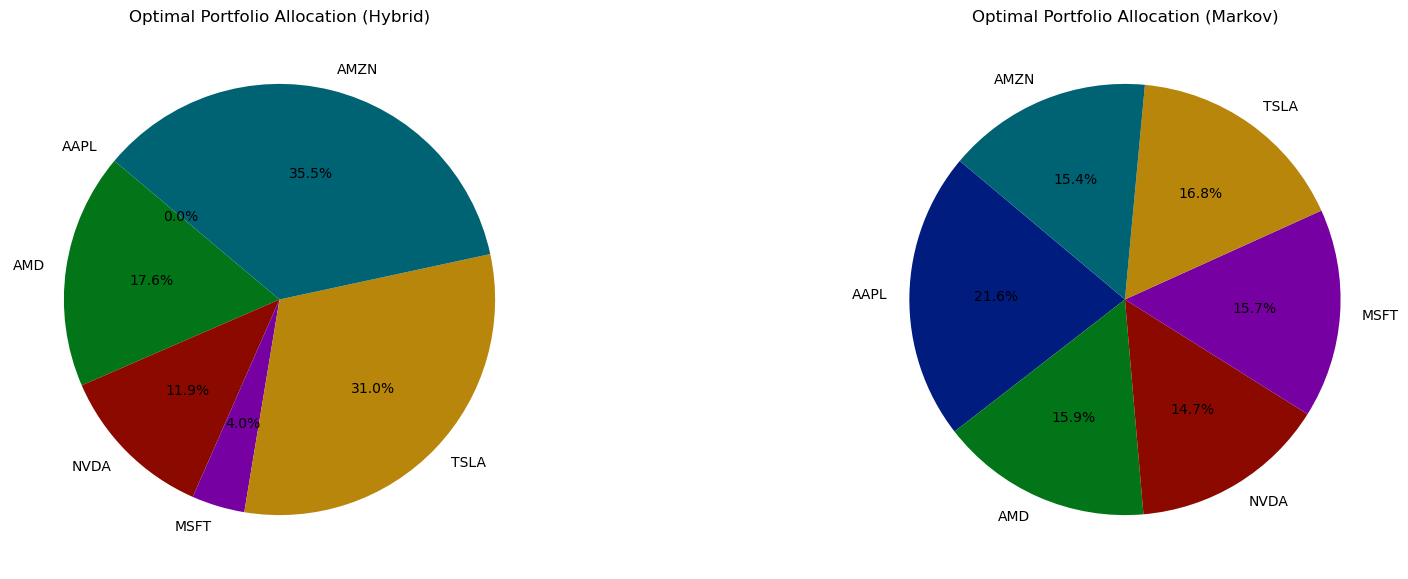

In [22]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot the first pie chart
axes[0].pie(optimal_weights_hybrid, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Optimal Portfolio Allocation (Hybrid)')

# Plot the second pie chart
axes[1].pie(optimal_weights_markov, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Optimal Portfolio Allocation (Markov)')

# Set the figure and axes background color to white
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')

plt.show() 

#### 12. Comparing returns of next day of both portfolios

In [23]:
print('End date : ',end_date)
end_date_str = datetime.strptime(end_date, '%Y-%m-%d')
next_day = end_date_str + timedelta(days=1)
next_day_str = next_day.strftime('%Y-%m-%d')
print('Next day : ',next_day) 

End date :  2019-12-30
Next day :  2019-12-31 00:00:00


In [24]:
data_next = pd.DataFrame()
for tick in tickers:
    data_next[f'{tick}'] = yf.download(tick,start='2019-12-30',end='2020-01-01')['Adj Close'] 
data_next     

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
Date,,,,,,
2019-12-30,70.815498,45.520000,5.784647,151.306503,27.646667,92.344498
2019-12-31,71.332901,45.860001,5.858846,151.412109,27.888666,92.391998


In [25]:
df_hybrid = pd.DataFrame(index=tickers) 

df_hybrid['Yesterday'] = data_next.iloc[0].values
df_hybrid['Today'] = data_next.iloc[1].values

optimal_weights_hybrid_dict = dict(zip(tickers, optimal_weights_hybrid)) 
df_hybrid['Optimal Weights Hybrid (%)'] = (df_hybrid.index.map(optimal_weights_hybrid_dict)).round(6)

df_hybrid['Yesterday Values'] = df_hybrid['Yesterday']*df_hybrid['Optimal Weights Hybrid (%)']
df_hybrid['Today Values'] = df_hybrid['Today']*df_hybrid['Optimal Weights Hybrid (%)']

df_hybrid  

,Yesterday,Today,Optimal Weights Hybrid (%),Yesterday Values,Today Values
AAPL,70.815498,71.332901,0.000000,0.000000,0.000000
AMD,45.520000,45.860001,0.176287,8.024584,8.084522
NVDA,5.784647,5.858846,0.118928,0.687956,0.696781
MSFT,151.306503,151.412109,0.039771,6.017611,6.021811
TSLA,27.646667,27.888666,0.309905,8.567840,8.642837
AMZN,92.344498,92.391998,0.355109,32.792362,32.809230


Calculating Total Portfolio value yesterday and today

In [26]:
total_value_yesterday = np.sum(df_hybrid['Yesterday Values'])
total_value_today = np.sum(df_hybrid['Today Values']) 

portfolio_return_hybrid = (total_value_today - total_value_yesterday) / total_value_yesterday

print(f"Total Portfolio Value Yesterday: ${total_value_yesterday:.2f}")
print(f"Total Portfolio Value Today: ${total_value_today:.2f}")
print(f"Portfolio Return: {portfolio_return_hybrid:.4f} or {portfolio_return_hybrid * 100:.2f}%") 

Total Portfolio Value Yesterday: $56.09
Total Portfolio Value Today: $56.26
Portfolio Return: 0.0029 or 0.29%


In [27]:
df_markov = pd.DataFrame(index=tickers) 

df_markov['Yesterday'] = data_next.iloc[0].values
df_markov['Today'] = data_next.iloc[1].values

optimal_weights_markov_dict = dict(zip(tickers, optimal_weights_markov))
df_markov['Optimal Weights Markov (%)'] = df_markov.index.map(optimal_weights_markov_dict)

df_markov['Yesterday Values'] = df_markov['Yesterday']*df_markov['Optimal Weights Markov (%)']
df_markov['Today Values'] = df_markov['Today']*df_markov['Optimal Weights Markov (%)']

df_markov  

,Yesterday,Today,Optimal Weights Markov (%),Yesterday Values,Today Values
AAPL,70.815498,71.332901,0.216052,15.299815,15.411601
AMD,45.520000,45.860001,0.158746,7.226126,7.280100
NVDA,5.784647,5.858846,0.147114,0.851003,0.861919
MSFT,151.306503,151.412109,0.156863,23.734464,23.751029
TSLA,27.646667,27.888666,0.167567,4.632682,4.673233
AMZN,92.344498,92.391998,0.153657,14.189379,14.196677


In [28]:
totalm_value_yesterday = np.sum(df_markov['Yesterday Values'])
totalm_value_today = np.sum(df_markov['Today Values']) 

portfolio_return_markov = (totalm_value_today - totalm_value_yesterday) / totalm_value_yesterday

print(f"Total Portfolio Value Yesterday: ${totalm_value_yesterday:.2f}")
print(f"Total Portfolio Value Today: ${totalm_value_today:.2f}")
print(f"Portfolio Return: {portfolio_return_markov:.4f} or {portfolio_return_markov * 100:.2f}%")  

Total Portfolio Value Yesterday: $65.93
Total Portfolio Value Today: $66.17
Portfolio Return: 0.0037 or 0.37%


#### Calculate the value of each stock in the portfolio yesterday and today

In [29]:
print(f'Returns from Markov Model : {portfolio_return_markov*100:.2f}% or {portfolio_return_markov*1000:.2f}$ for an investment of 1000$ in the portfolio') 
print(f'Returns from Hybrid Model : {portfolio_return_hybrid*100:.2f}% or {portfolio_return_hybrid*1000:.2f}$ for an investment of 1000$ in the portfolio') 

Returns from Markov Model : 0.37% or 3.66$ for an investment of 1000$ in the portfolio
Returns from Hybrid Model : 0.29% or 2.94$ for an investment of 1000$ in the portfolio
